In [15]:
ownerpath = f'/content/drive/MyDrive/AST 443 Group 5'

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
import os
from matplotlib import pyplot as plt
from matplotlib import colors
from astropy.io import fits
from IPython.display import Image
import math
import numpy as np

import glob
import matplotlib.colors as colors
from astropy.io import ascii
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
from astropy.visualization import make_lupton_rgb
from astropy.table import Table
from astroquery.astrometry_net import AstrometryNet
from astropy.stats import sigma_clipped_stats

from photutils.datasets import load_star_image
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization import simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
AstrometryNet.key = 'kwbavttkhitkoaeo'

%matplotlib inline

from scipy import stats
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [18]:
!pip install photutils

In [19]:
!pip install astroquery

In [47]:
!pip install numpy astropy scipy

In [20]:
dark_frame = []
for i in range(10):
    filename = f'{ownerpath}/Lab 2/Darks/HAT_P_16_VISIBLE_DARK_20S_.0000000{i}.DARK.FIT'
    dark_f = fits.getdata(filename)
    dark_frame.append(dark_f)

In [21]:
master_dark_data = np.median(dark_frame, axis=0)

In [22]:
dark_frame_3 = []
for i in range(5):
    filename = f'{ownerpath}/Lab 1 CCD/Group 5 data lab1/Picture of Object/Andromena/Dark/Andromeda_Visible_Dark_3s_.0000000{i}.DARK.FIT'
    dark_f3 = fits.getdata(filename)
    dark_frame_3.append(dark_f3)

In [23]:
master_dark_data3 = np.median(dark_frame_3, axis=0)

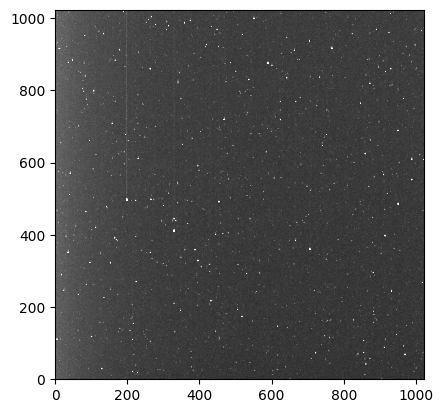

In [24]:
plt.imshow(master_dark_data3, cmap='gray', vmax=np.mean(master_dark_data3)+(np.std(master_dark_data3)), origin='lower')

In [25]:
file_num=[1,2,3,4,5,6,7,8,9]
flat_fields_data=[]

for i in range(len(file_num)):
    field_file=f'{ownerpath}/Lab 1 CCD/Group 5 data lab1/Photometry/Flats/flat_0C_2s_visible_.0000000{i}.FLAT.FIT'
    field_file_data=fits.open(field_file)
    flat_fields_data.append(field_file_data[0].data)

# Compute the median flat field
median_flat_field = np.median(flat_fields_data, axis=0)

In [26]:
# Normalizing the flat field
master_flat_field=median_flat_field/np.max(median_flat_field)


In [27]:
master_flat = fits.getdata(f'{ownerpath}/Lab 1 CCD/Group 5 data lab1/Photometry/Flats/Normalized_Master_Flat-Field.FIT')

#master_flat_n = (master_flat - master_dark_data)
#master_flat_normalized = master_flat_n / np.median(master_flat_n)

In [28]:
science_files = []

for i in range(194):
    if i < 10:
        filename = f'{ownerpath}/Lab 2/Transient/HAT_P_16_VISIBLE_LIGHT_20S_.0000000{i}.FIT'
    elif i < 100 :
        filename = f'{ownerpath}/Lab 2/Transient/HAT_P_16_VISIBLE_LIGHT_20S_.000000{i}.FIT'
    else:
        filename = f'{ownerpath}/Lab 2/Transient/HAT_P_16_VISIBLE_LIGHT_20S_.00000{i}.FIT'
    science_data = fits.getdata(filename)
    science_files.append(science_data)

In [31]:
calibrated_science_withflat = []
for i in range(194):
    science_corrected = (science_files[i] - master_dark_data)/master_flat_field
    calibrated_science_withflat.append(science_corrected)

    output_file_with = f'{ownerpath}/Lab 2/Subtracted Transient(withflat)/HAT_P_16_VISIBLE_LIGHT_20S_.{i}.fits'
    hdu = fits.PrimaryHDU(science_corrected)
    hdu.writeto(output_file_with, overwrite=True)

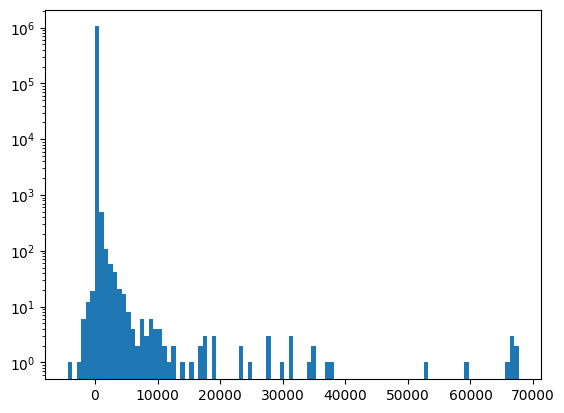

In [32]:
flatten_cal_science=calibrated_science_withflat[0].flatten()
plt.hist(flatten_cal_science, bins=100)
plt.yscale('log')

In [ ]:
# calibrated_science_withflat = []
# for i in range(194):
#     science_corrected = science_files[i] - master_dark_data
#     calibrated_data_with =  science_corrected / master_flat
#     calibrated_science_withflat.append(calibrated_data_with)

#     output_file_with = f'{ownerpath}/Lab 2/Subtracted Transient(withflat)/HAT_P_16_VISIBLE_LIGHT_20S_.{i}.fits'
#     hdu = fits.PrimaryHDU(calibrated_data_with)
#     hdu.writeto(output_file_with, overwrite=True)

In [ ]:
# calibrated_science_withoutflat = []
# for i in range(194):
#     science_corrected = science_files[i] - master_dark_data
#     calibrated_data_without =  science_corrected / np.mean(science_corrected)
#     calibrated_science_withoutflat.append(calibrated_science_withoutflat)

#     output_file_without = f'{ownerpath}/Lab 2/Subtracted Transient(withoutflat)/HAT_P_16_VISIBLE_LIGHT_20S_.{i}.fits'
#     hdu = fits.PrimaryHDU(calibrated_data_without)
#     hdu.writeto(output_file_without, overwrite=True)

In [ ]:
# data = fits.getdata(f'{ownerpath}/Lab 2/Subtracted Transient(withflat)/HAT_P_16_VISIBLE_LIGHT_20S_.0.fits')
# mean, median, std = sigma_clipped_stats(data, sigma=3.0)
# print(np.array((mean, median, std)))

In [33]:
mean, median, std = sigma_clipped_stats(calibrated_science_withflat[0], sigma=3.0)
print(np.array((mean, median, std)))

[248.38998673 248.27127572  15.04731646]


In [34]:
daofind = DAOStarFinder(fwhm=10.0, threshold=10.*std)
sources = daofind(calibrated_science_withflat[0] - median)
for col in sources.colnames:
    if col not in ('id', 'npix'):
        sources[col].info.format = '%.2f'
sources.pprint(max_width=76)
sources.write(f'{ownerpath}/Lab 2/Subtracted Transient(withflat)/sources.txt', format='ascii', overwrite=True)

 id xcentroid ycentroid sharpness roundness1 ... sky    peak   flux  mag 
--- --------- --------- --------- ---------- ... ---- ------- ----- -----
  1    307.29     17.53      0.91       0.09 ... 0.00  137.22  1.92 -0.71
  2    974.33     30.23      0.54       0.22 ... 0.00   62.05  1.38 -0.35
  3    453.31     35.35      0.82      -0.03 ... 0.00   95.54  1.48 -0.43
  4    488.44     40.14      0.55       0.31 ... 0.00   53.06  1.12 -0.12
  5    323.26     59.80      0.86       0.25 ... 0.00  129.81  1.98 -0.74
  6    435.31     77.48      0.94      -0.17 ... 0.00  162.06  2.30 -0.90
  7     39.27    167.40      0.76      -0.09 ... 0.00 2198.05 35.64 -3.88
  8      8.31    180.77      0.76      -0.28 ... 0.00   59.53  1.03 -0.04
  9    885.40    216.41      0.98      -0.02 ... 0.00 2992.52 39.91 -4.00
 10    934.33    219.34      0.97      -0.37 ... 0.00   96.22  1.27 -0.26
...       ...       ...       ...        ... ...  ...     ...   ...   ...
 59    153.75    909.52      0.72     

In [35]:
dir(DAOStarFinder)

['__abstractmethods__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_find_stars',
 '_get_raw_catalog',
 'find_stars']

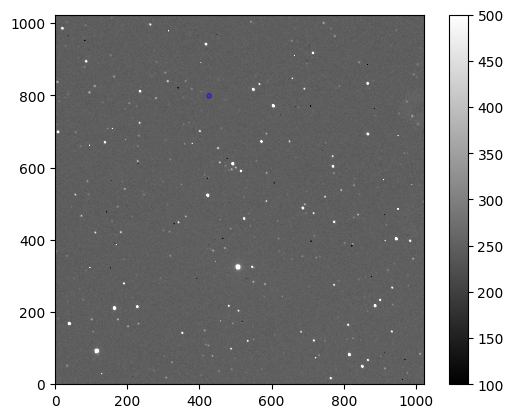

In [36]:
norm = simple_norm(calibrated_science_withflat[0], 'sqrt')

positions = np.transpose((426.9475, 798.2625))
apertures = CircularAperture(positions, r=5.0)

plt.imshow(calibrated_science_withflat[0], cmap='gray', origin='lower', vmin=100, vmax=500)
apertures.plot(color='blue', lw=1.5, alpha=0.5)
plt.colorbar()
plt.show()

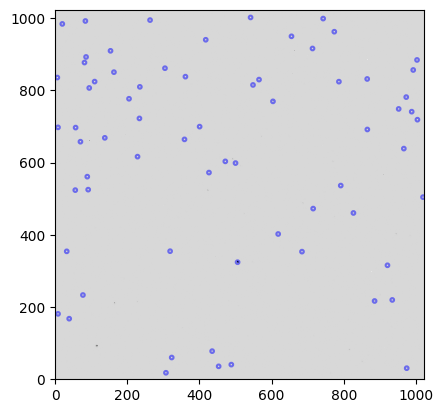

In [37]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=5.0)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(calibrated_science_withflat[0], cmap='Greys', origin='lower', norm=norm,
           interpolation='nearest')
apertures.plot(color='blue', lw=1.5, alpha=0.5)
plt.show()

In [ ]:
# ast = AstrometryNet()
# ast.api_key = 'zxdmyndauvanohii'

# sources = Table.read(f'{ownerpath}/Lab 2/Subtracted Transient(withflat)/sources.txt', format='ascii')
# # Sort sources in ascending order
# sources.sort('flux')
# # Reverse to get descending order
# sources.reverse()

# image_width = 1024
# image_height = 1024
# wcs_header = ast.solve_from_source_list(sources['xcentroid'], sources['ycentroid'],
#                                         image_width, image_height, solve_timeout=120)

In [38]:
ast = AstrometryNet()
ast.api_key = 'kwbavttkhitkoaeo'

sources = Table.read(f'{ownerpath}/Lab 2/Subtracted Transient(withflat)/sources.txt', format='ascii')
# Sort sources in ascending order
sources.sort('flux')
# Reverse to get descending order
sources.reverse()

image_width = 1024
image_height = 1024
wcs_header = ast.solve_from_source_list(sources['xcentroid'], sources['ycentroid'],
                                        image_width, image_height, solve_timeout=120)

Solving................................

In [39]:
wcs_header

SIMPLE  =                    T / Standard FITS file                             
BITPIX  =                    8 / ASCII or bytes array                           
NAXIS   =                    0 / Minimal header                                 
EXTEND  =                    T / There may be FITS ext                          
WCSAXES =                    2 / no comment                                     
CTYPE1  = 'RA---TAN-SIP' / TAN (gnomic) projection + SIP distortions            
CTYPE2  = 'DEC--TAN-SIP' / TAN (gnomic) projection + SIP distortions            
EQUINOX =               2000.0 / Equatorial coordinates definition (yr)         
LONPOLE =                180.0 / no comment                                     
LATPOLE =                  0.0 / no comment                                     
CRVAL1  =        9.68152412307 / RA  of reference point                         
CRVAL2  =        42.4411103366 / DEC of reference point                         
CRPIX1  =             426.94

In [ ]:
Number of WCS axes: 2 (WCSAXES = 2)
CTYPE1 = 'RA---TAN-SIP'
CTYPE2 = 'DEC--TAN-SIP'

CRVAL1 = 9.68152412307 (RA of reference point)
CRVAL2 = 42.4411103366 (DEC of reference point)

CRPIX1 = 426.9475 (X reference pixel)
CRPIX2 = 798.2625 (Y reference pixel)

NAXIS: 0 (NAXIS = 0)

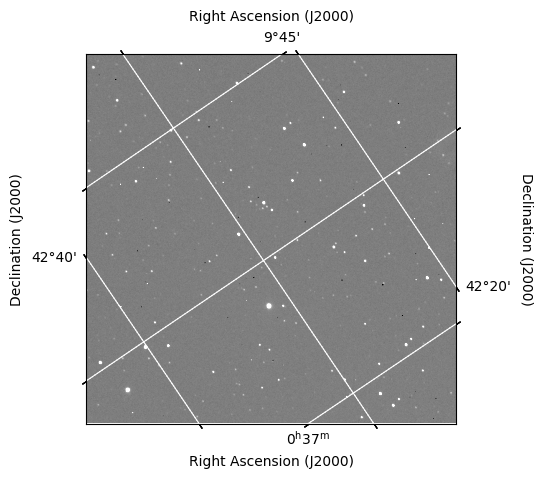

In [42]:
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.io import fits

# Load calibrated data
calibrated_data = calibrated_science_withflat[0]

# Create a WCS object using our wcs header
wcs = WCS(wcs_header)

# Create a plot with the WCS projection
ax = plt.subplot(projection=wcs, label='overlays')

# Display calibrated data
ax.imshow(calibrated_data, cmap='gray', vmax=np.mean(calibrated_data)+(np.std(calibrated_data)), vmin=np.mean(calibrated_data)-(np.std(calibrated_data)), origin='lower')

# Enable grid and set axis labels
ax.coords.grid(True, color='white', ls='solid')
ax.coords[0].set_axislabel('Right Ascension (J2000)')
ax.coords[1].set_axislabel('Declination (J2000)')

# Create an overlay coordinate system
overlay = ax.get_coords_overlay('fk5')
overlay.grid(color='white', ls='dotted')
overlay[0].set_axislabel('Right Ascension (J2000)')
overlay[1].set_axislabel('Declination (J2000)')

# Show the plot
plt.show()

In [46]:
good_frames=[]
for i in range(len(calibrated_science_withflat)):
        if np.mean(calibrated_science_withflat[i])<300:
            good_frames.append([i,np.mean(calibrated_science_withflat[i]), np.std(calibrated_science_withflat[i])])
print(good_frames)
print(len(good_frames))

[[0, 251.12359329873425, 228.25641047923264], [1, 250.69264730472455, 228.89698872367012], [2, 250.57099039079773, 220.26424160084653], [3, 248.5932401787493, 222.0805667035862], [4, 246.7536954102181, 229.3427708467804], [5, 247.39577508636057, 231.44819992519916], [6, 247.8227139903314, 233.002111336097], [7, 250.25401987090714, 230.40360181079313], [8, 249.12841300932044, 228.81916121568236], [9, 248.5019945996759, 230.26928689188517], [10, 247.95363229521135, 225.72625366243474], [11, 248.7639319528463, 228.2805725614729], [12, 249.38602111916907, 229.3182416434598], [13, 247.71139216188325, 228.2429762729792], [14, 248.62267253988637, 224.65265964166346], [15, 251.11134340371737, 219.12994494177573], [16, 250.02512197708145, 226.4581147188654], [17, 252.54433052008147, 226.00228240780558], [18, 250.5563628435471, 227.43916746560672], [19, 250.2929266036754, 225.2705129506125], [20, 249.37117327756863, 225.1991962435926], [21, 251.69583519115128, 227.08468365221432], [22, 252.34913

Align Images

In [57]:
import numpy as np
from astropy.io import fits
from scipy.ndimage import shift

def load_fits_images(filenames):
    return [fits.getdata(f) for f in filenames]

def align_images(images, star_coords, center_coords):
    aligned_images = []

    for img, (star_x, star_y) in zip(images, star_coords):
        x_offset = center_coords[0] - star_x
        y_offset = center_coords[1] - star_y
        aligned_img = shift(img, shift=(y_offset, x_offset), mode='nearest')
        aligned_images.append(aligned_img)

    return aligned_images

def save_aligned_images(aligned_images, ownerpath):
    for i, aligned_img in enumerate(aligned_images):
        hdu = fits.PrimaryHDU(aligned_img)
        hdu.writeto(f'{ownerpath}/Lab 2/Aligned Images/aligned_HAT_P_16_VISIBLE_LIGHT_20S_.{i}.fits', overwrite=True)


# List of your FITS files with full paths
filenames = [f'{ownerpath}/Lab 2/Subtracted Transient(withflat)/HAT_P_16_VISIBLE_LIGHT_20S_.{i}.fits' for i in [
    0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
    16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30, 31,
    33, 37, 38, 39, 42, 43, 59, 63, 70, 71, 72, 75, 84, 85,
    86, 89, 91, 93, 94, 95, 102, 103, 104, 107, 108, 109,
    111, 112, 114, 115, 116, 118, 120, 121, 122, 126
]]

# Coordinates of the star in each image
star_coords = [
    (493.338, 609.667), (490.2, 613.8), (501, 595.338), (498.6, 600.6),
    (496.2, 604.2), (513, 577.338), (540, 535.338), (537.2, 539.667),
    (533.338, 543.338), (530.5, 548.338), (528, 552.2), (524.667, 556.3),
    (522.2, 560.5), (518.338, 564.667), (516.3, 568.338), (513, 572.2),
    (510.5, 575.5), (507.2, 579.667), (503.338, 583.5), (501, 587.2),
    (489, 590.5), (494.667, 594.667), (492.2, 598.338), (488.338, 602.2),
    (485.5, 606.3), (482.2, 610.5), (473, 621.3), (470.5, 624.667),
    (466.338, 628.5), (463.338, 632.2), (457.2, 639.667), (445, 653.338),
    (441.667, 657.338), (438.667, 660.5), (429.667, 670.667), (426, 674.338),
    (410, 671.667), (396.833, 683.5), (438, 605.5), (434.667, 608),
    (431.3, 610.5), (419.667, 619.667), (386.3, 644.667), (382.167, 647.2),
    (378.833, 650.5), (368, 658), (359.667, 663.883), (352.2, 669.667),
    (348.833, 673), (344.667, 675.5), (316, 696.3), (312.2, 698.833),
    (308.5, 701.883), (394.3, 561.833), (443.833, 485.5), (492.2, 408.833),
    (484.667, 413), (481.3, 414.667), (473, 418.833), (469.667, 421.3),
    (466.3, 423), (458, 427.2), (450.5, 432.2), (446.3, 433.833),
    (442.2, 436.3), (425.5, 44.667)
]

# Center coordinates of the images
center_coords = (512, 512)  # For a 1024x1024 image

# Load images
images = load_fits_images(filenames)

# Align images
aligned_images = align_images(images, star_coords, center_coords)

# Save aligned images
save_aligned_images(aligned_images, ownerpath)

print("Alignment complete. Aligned images saved.")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/AST 443 Group 5/Lab 2/Aligned Images/Lab 2/Subtracted Transient(withflat)/HAT_P_16_VISIBLE_LIGHT_20S_.0.fits'

In [58]:
import numpy as np
from astropy.io import fits
from scipy.ndimage import shift
import os

# Define paths
input_directory = "/content/drive/MyDrive/AST 443 Group 5/Lab 2/Subtracted Transient(withflat)"
output_directory = "/content/drive/MyDrive/AST 443 Group 5/Lab 2/Aligned Images"

# List of specific FITS files to process
filenames = [f'HAT_P_16_VISIBLE_LIGHT_20S_.{i}.fits' for i in [
    0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
    16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30, 31,
    33, 37, 38, 39, 42, 43, 59, 63, 70, 71, 72, 75, 84, 85,
    86, 89, 91, 93, 94, 95, 102, 103, 104, 107, 108, 109,
    111, 112, 114, 115, 116, 118, 120, 121, 122, 126
]]

# Star coordinates in each image
star_coords = [
    (493.338, 609.667), (490.2, 613.8), (501, 595.338), (498.6, 600.6),
    (496.2, 604.2), (513, 577.338), (540, 535.338), (537.2, 539.667),
    (533.338, 543.338), (530.5, 548.338), (528, 552.2), (524.667, 556.3),
    (522.2, 560.5), (518.338, 564.667), (516.3, 568.338), (513, 572.2),
    (510.5, 575.5), (507.2, 579.667), (503.338, 583.5), (501, 587.2),
    (489, 590.5), (494.667, 594.667), (492.2, 598.338), (488.338, 602.2),
    (485.5, 606.3), (482.2, 610.5), (473, 621.3), (470.5, 624.667),
    (466.338, 628.5), (463.338, 632.2), (457.2, 639.667), (445, 653.338),
    (441.667, 657.338), (438.667, 660.5), (429.667, 670.667), (426, 674.338),
    (410, 671.667), (396.833, 683.5), (438, 605.5), (434.667, 608),
    (431.3, 610.5), (419.667, 619.667), (386.3, 644.667), (382.167, 647.2),
    (378.833, 650.5), (368, 658), (359.667, 663.883), (352.2, 669.667),
    (348.833, 673), (344.667, 675.5), (316, 696.3), (312.2, 698.833),
    (308.5, 701.883), (394.3, 561.833), (443.833, 485.5), (492.2, 408.833),
    (484.667, 413), (481.3, 414.667), (473, 418.833), (469.667, 421.3),
    (466.3, 423), (458, 427.2), (450.5, 432.2), (446.3, 433.833),
    (442.2, 436.3), (425.5, 44.667)
]

# Center of the image
center_coords = (512, 512)  # For a 1024x1024 image

# Function to load images
def load_fits_images(filepaths):
    return [fits.getdata(fp) for fp in filepaths]

# Function to align images
def align_images(images, star_coords, center_coords):
    aligned_images = []
    for img, (star_x, star_y) in zip(images, star_coords):
        x_offset = center_coords[0] - star_x
        y_offset = center_coords[1] - star_y
        aligned_img = shift(img, shift=(y_offset, x_offset), mode='nearest')
        aligned_images.append(aligned_img)
    return aligned_images

# Function to save aligned images
def save_aligned_images(aligned_images, output_directory, base_name):
    for i, aligned_img in enumerate(aligned_images):
        hdu = fits.PrimaryHDU(aligned_img)
        hdu.writeto(os.path.join(output_directory, f"{base_name}.{i}.fits"), overwrite=True)

# Load images
filepaths = [os.path.join(input_directory, fname) for fname in filenames]
images = load_fits_images(filepaths)

# Align images
aligned_images = align_images(images, star_coords, center_coords)

# Save aligned images
save_aligned_images(aligned_images, output_directory, "aligned_HAT_P_16_VISIBLE_LIGHT_20S_")

print("Alignment complete. Aligned images saved.")

Alignment complete. Aligned images saved.
